In [1]:
# Filter warnings for readability
import warnings
warnings.filterwarnings('ignore')

Imports

In [2]:
import pandas as pd
from transformers import pipeline
import torch
from wordcloud import WordCloud
import yaml

with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

c:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0709 08:45:44.089000 4488 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Read Preprocessed Data

In [3]:
preprocessed_df = pd.read_csv('preprocessed_df.csv')

In [4]:
preprocessed_df.head()

,title
0,DSWD DROMIC Report on the Tornado Incident in ...
1,New state report : Wildfire smoke increased de...
2,New Year Day flood alerts issued in Cambridges...
3,Gold Coast flash flooding danger : Weather ale...
4,"Almost 100 , 000 ordered to leave area after J..."


In [5]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27533 entries, 0 to 27532
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   27533 non-null  object
dtypes: object(1)
memory usage: 215.2+ KB


### __Step 1__: Build a *Multi-Label Zero-Shot-Classifier*

In [6]:
labels = ["Earthquake", "Floods", "Volcano", "Tornado", "Wildfire"]

if torch.cuda.is_available():
    print("Using GPU")
    classifier = pipeline("zero-shot-classification", model=config['zero_shot_model_gpu'], device=0) # Use GPU
    results = classifier(preprocessed_df['title'].tolist(), candidate_labels=labels, batch_size=config['batch_size_gpu'])
else:
    print("Using CPU")
    classifier = pipeline("zero-shot-classification", model=config['zero_shot_model_cpu'], device=-1) # Use CPU
    results = classifier(preprocessed_df['title'].tolist(), candidate_labels=labels, batch_size=config['batch_size_cpu'])

Using GPU


Example Result

In [7]:
results[0]

{'sequence': 'DSWD DROMIC Report on the Tornado Incident in Brgy . Rizal , Anao , Tarlac , 30 December 2023 , 6PM - Philippines',
 'labels': ['Tornado', 'Volcano', 'Floods', 'Wildfire', 'Earthquake'],
 'scores': [0.9847111701965332,
  0.004728720057755709,
  0.0037104268558323383,
  0.003552090609446168,
  0.003297568764537573]}

In [ ]:
# Free up CUDA cores:
del classifier
del results
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [8]:
parsed = [
    {
        "natural_catastrophe_event": r["labels"][0],
        "zero_shot_score": r["scores"][0]
    }
    for r in results
]

In [9]:
preprocessed_df[["natural_catastrophe_event", "zero_shot_score"]] =  pd.DataFrame(parsed)

In [10]:
preprocessed_df.head()

,title,natural_catastrophe_event,zero_shot_score
0,DSWD DROMIC Report on the Tornado Incident in ...,Tornado,0.984711
1,New state report : Wildfire smoke increased de...,Wildfire,0.979571
2,New Year Day flood alerts issued in Cambridges...,Floods,0.947202
3,Gold Coast flash flooding danger : Weather ale...,Floods,0.969083
4,"Almost 100 , 000 ordered to leave area after J...",Earthquake,0.961765


In [11]:
preprocessed_df.to_csv('segmented_result.csv', index=False)

### Post-Modelling Analysis

In [3]:
preprocessed_df = pd.read_csv('segmented_result.csv')

In [4]:
preprocessed_df['natural_catastrophe_event'].value_counts()

natural_catastrophe_event
Floods        8295
Earthquake    5562
Tornado       5031
Wildfire      4534
Volcano       4111
Name: count, dtype: int64

C:\Users\james\AppData\Local\Temp\ipykernel_4488\1826689834.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


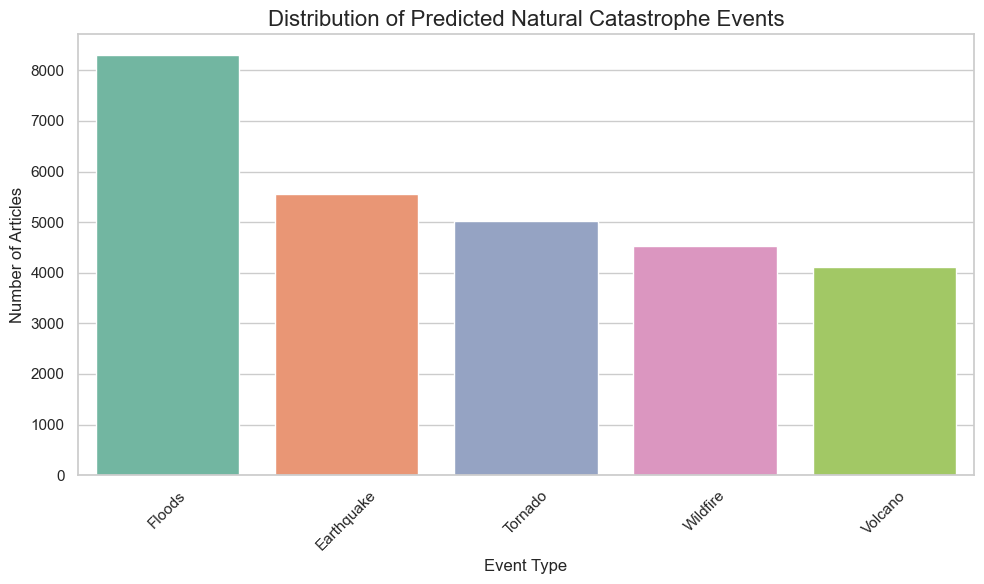

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set a clean style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(
    data=preprocessed_df, 
    x="natural_catastrophe_event", 
    order=preprocessed_df["natural_catastrophe_event"].value_counts().index,
    palette="Set2"
)

# Add labels and title
plt.title("Distribution of Predicted Natural Catastrophe Events", fontsize=16)
plt.xlabel("Event Type", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\james\AppData\Local\Temp\ipykernel_4488\14931184.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


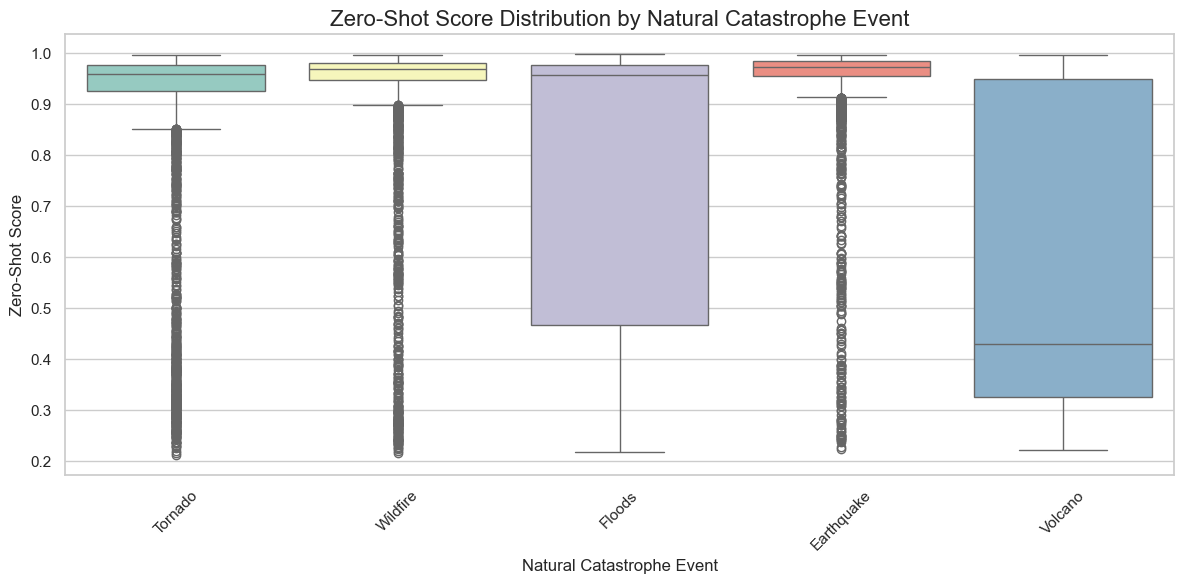

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=preprocessed_df,
    x="natural_catastrophe_event",
    y="zero_shot_score",
    palette="Set3"
)

# Labeling
plt.title("Zero-Shot Score Distribution by Natural Catastrophe Event", fontsize=16)
plt.xlabel("Natural Catastrophe Event", fontsize=12)
plt.ylabel("Zero-Shot Score", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\james\AppData\Local\Temp\ipykernel_4488\1540872317.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(preprocessed_df["zero_shot_score"], shade=True, color="purple")


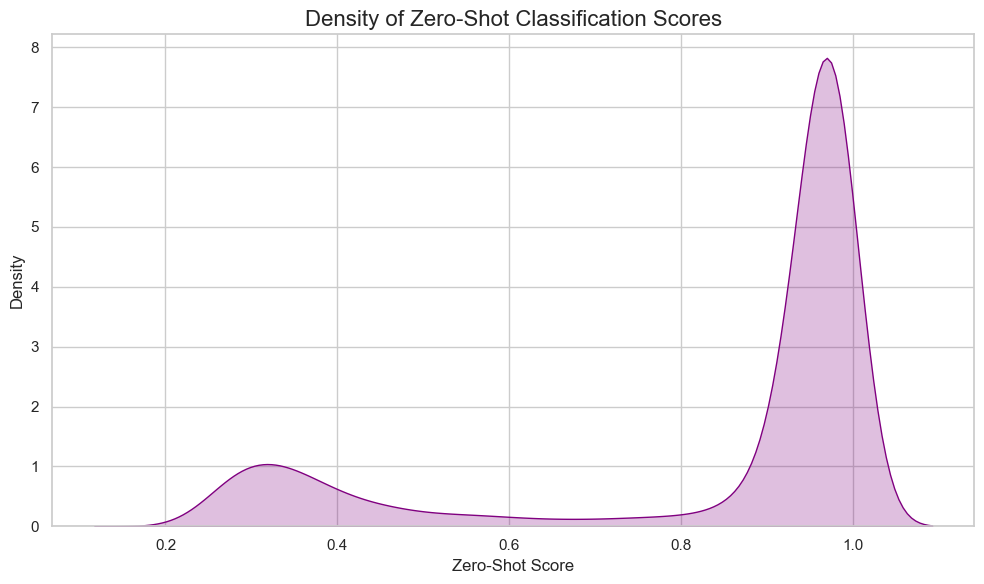

In [7]:
plt.figure(figsize=(10, 6))
sns.kdeplot(preprocessed_df["zero_shot_score"], shade=True, color="purple")

plt.title("Density of Zero-Shot Classification Scores", fontsize=16)
plt.xlabel("Zero-Shot Score", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


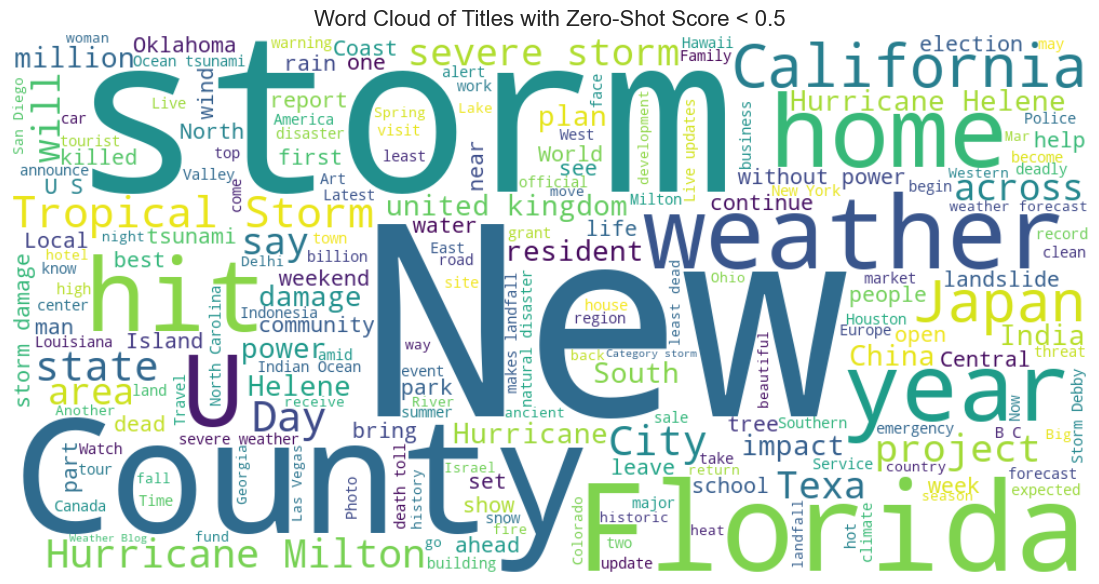

In [9]:
import matplotlib.pyplot as plt

# Filter titles with low confidence
low_score_titles = preprocessed_df[preprocessed_df["zero_shot_score"] < 0.5]["title"]

# Combine all titles into one string
text_blob = " ".join(low_score_titles.astype(str).tolist())

# Generate word cloud
wordcloud = WordCloud(width=1000, height=500, background_color="white", colormap="viridis").generate(text_blob)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Titles with Zero-Shot Score < 0.5", fontsize=16)
plt.tight_layout()
plt.show()
